## Hierarchical LSTM Attention
This model was implemented based on Yang et al. (2016) which specifically targets document classifications. It has two levels of attention mechanisms, the first one creates vectors that represent each sentence, using attention mechanism across words; and the second level creates a vector that represent the document using attention mechanisms across sentences. Yang et al. (2016) uses Bidirectional GRUs while we use LSTMs for a fair comparision with the flat LSTM models.

https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf

In [3]:
# General imports
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import random


#keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate

from nltk import tokenize
import re
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

# Custom functions
%load_ext autoreload
%autoreload 2
import database_selection
import vectorization
import helpers
import icd9_cnn_model
import hatt_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Input File

In [2]:
#reading file
full_df = pd.read_csv('../data/disch_notes_all_icd9.csv',
                 names = ['HADM_ID', 'SUBJECT_ID', 'DATE', 'ICD9','TEXT'])
# taking just a subset of the records for developing models
df = full_df.sample(frac=0.1).reset_index(drop=True)
print df.shape
#df.head(10)

(5270, 5)


## Pre processing ICD 9 codes

In [4]:
#Source: https://github.com/sirrice/icd9 plus doing queries with it
ICD9_FIRST_LEVEL = [
    '001-139','140-239','240-279','290-319', '320-389', '390-459','460-519', '520-579', '580-629', 
    '630-679', '680-709','710-739', '760-779', '780-789', '790-796', '797', '798', '799', '800-999' ]
N_TOP = len(ICD9_FIRST_LEVEL)
# replacing leave ICD9 codes with the grandparents
df['ICD9'] = df['ICD9'].apply(lambda x: helpers.replace_with_grandparent_codes(x,ICD9_FIRST_LEVEL))
#df.head(10)

In [5]:
#preprocess icd9 codes
top_codes = ICD9_FIRST_LEVEL
labels = vectorization.vectorize_icd_column(df, 'ICD9', top_codes)

## Preprocess Notes

Notes preprocessing here is a little different sice we want to keep dots and other characters to be able to split the notes into sentences

### tokenize sentences

In [8]:
def clean_clinical_note(string):
    # remove the things inside the [** **]
    string = re.sub("\[\*\*.*?\*\*\]", "", string)
    """ Canonize numbers"""
    string = re.sub(r"(\d+)", "DG", string)
    return string.strip().lower()

In [9]:
note_sentences = []
notes = []

for idx in range(df.shape[0]):
    # for every note
    text = clean_clinical_note(df["TEXT"][idx].encode('ascii','ignore'))
    notes.append(text)
    sentences = tokenize.sent_tokenize(text)
    note_sentences.append(sentences)   



In [10]:
note_sentences[0][0:5]

['admission date:       discharge date:   service:  micu history of present illness:  the patient is an dg-year-old african-american male with a known history of prostate cancer, carcinoid syndrome and interstitial lung disease secondary to asbestos exposure with an admitted in  for pneumonia.',
 'at baseline, the patient has shortness of breath and dyspnea on exertion.',
 'two days prior to admission, the patient believes that he acquired a cold because he subsequently developed a cough that was nonproductive.',
 'the patient had mild wheezing and a temperature as high as dg.dg degrees one day prior to admission.',
 "the patient's shortness of breath increased with exertion and when lying flat."]

In [11]:
note_sentences_length =[len(x) for x in note_sentences]
print "Average number of sentences in a note: ", np.mean(note_sentences_length)  
print "Max number of sentences in a note: ", max(note_sentences_length)

Average number of sentences in a note:  125.137571157
Max number of sentences in a note:  554


In [12]:
sum(np.array(note_sentences_length) > 150)

1500

### tokenize words in sentences

In [13]:
MAX_NB_WORDS = None
MAX_VOCAB = None # to limit original number of words (None if no limit)
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(notes)


/home/zenla/anaconda2/lib/python2.7/site-packages/keras/preprocessing/text.py:139: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [14]:
notes_tokenized = []
sentence_length= []
for one_note_sentences in note_sentences:
    note_sentences_tokenized = []
    for sentence in one_note_sentences:
        sentence_words = text_to_word_sequence(sentence)
        sentence_length.append(len(sentence_words))
        note_sentences_tokenized.append(sentence_words)
    notes_tokenized.append(note_sentences_tokenized)
print len(notes_tokenized)                                        

5270


In [15]:
print "Average number of words in a sentence: ", np.mean(sentence_length)  
print "Max number of words in a sentence: ", max(sentence_length)

Average number of words in a sentence:  12.904238978
Max number of words in a sentence:  1847


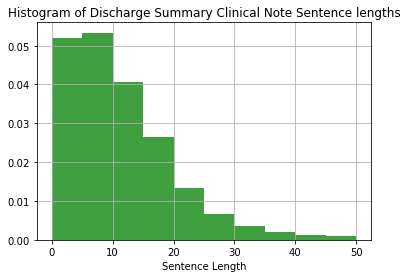

In [17]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(sentence_length,  normed=1, facecolor='green', alpha=0.75,range=(0,50))
plt.xlabel('Sentence Length')
plt.title('Histogram of Discharge Summary Clinical Note Sentence lengths')
plt.grid(True)

plt.show()

In [18]:
sum(np.array(sentence_length) > 250)

1074

In [19]:
# using another notebook, it was found that the long sentences were lab results, we can truncate them
#  icd9-codes are assigned based on clinical notes, administrative staff do not interprest lab results

In [20]:
dictionary = tokenizer.word_index

In [21]:
MAX_SENTS = 150
MAX_SENT_LENGTH  = 160

MAX_NB_WORDS = len(tokenizer.word_index)  #vocabulary length
note_matrix = np.zeros((len(notes), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, one_note_sentences in enumerate(note_sentences):
    for j, sentence in enumerate(one_note_sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sentence)
            k=0
            for _, word in enumerate(wordTokens):
                if k<MAX_SENT_LENGTH and tokenizer.word_index[word]<MAX_NB_WORDS:
                    note_matrix[i,j,k] = tokenizer.word_index[word]
                    k+=1

In [22]:
note_matrix[0][0]

array([  41,   45,   22,   45,   95,  492,   31,    4,  120,  212,    2,
         16,   15,   47,    1,  196,  216, 6856, 4618,  501,    7,    8,
        316,   31,    4, 1561,  447, 8171,  830,    3, 1877,  272,   84,
        223,    5, 5223, 3295,    7,   47,  160,   10,   11,  293,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## Split Files

In [23]:
#creating embeddings
#EMBEDDING_LOC = '../data/glove.6B.100d.txt' # location of embedding
EMBEDDING_LOC = '../data/notes.100.txt' # location of embedding
EMBEDDING_DIM = 100 # given the glove that we chose
EMBEDDING_MATRIX, embedding_dict = vectorization.embedding_matrix(EMBEDDING_LOC,
                                                                  dictionary, EMBEDDING_DIM, verbose = True)


('Vocabulary in notes:', 45518)
('Vocabulary in original embedding:', 21056)
('Vocabulary intersection:', 19945)


In [24]:
#split sets
X_train, X_val, X_test, y_train, y_val, y_test = helpers.train_val_test_split(
    note_matrix, labels, val_size=0.2, test_size=0.1, random_state=101)
print("Train: ", X_train.shape, y_train.shape)
print("Validation: ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

('Train: ', (3688, 150, 160), (3688, 19))
('Validation: ', (1054, 150, 160), (1054, 19))
('Test: ', (528, 150, 160), (528, 19))


## Hierarchical Attention NN
based on paper: Hierarchical Attention networks for document classification

In [28]:
reload(hatt_model)
h_att_model = hatt_model.build_hierarhical_att_model(MAX_SENTS, MAX_SENT_LENGTH, 
                         max_vocab=MAX_NB_WORDS, embedding_dim=EMBEDDING_DIM , embedding_matrix=EMBEDDING_MATRIX ,
                         num_classes=N_TOP,training_dropout=0.5)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 160)           0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 160, 100)      4551900     input_5[0][0]                    
____________________________________________________________________________________________________
bidirectional_5 (Bidirectional)  (None, 160, 100)      60400       embedding_3[0][0]                
____________________________________________________________________________________________________
time_distributed_7 (TimeDistribu (None, 160, 50)       5050        bidirectional_5[0][0]            
___________________________________________________________________________________________

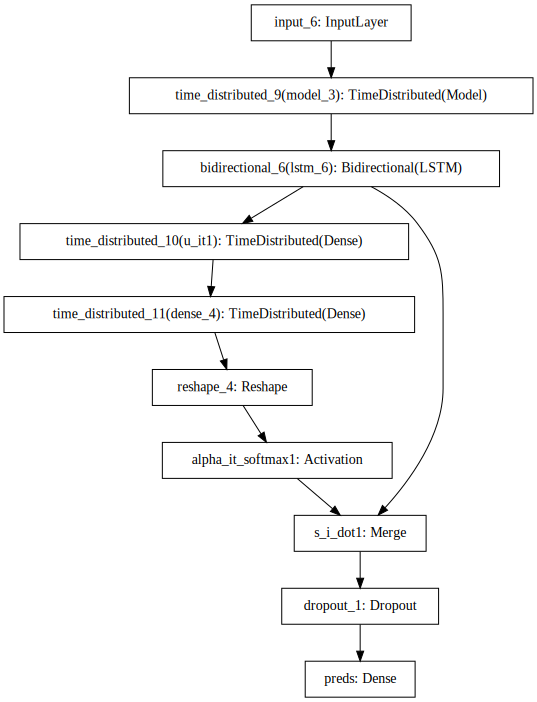

In [29]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(h_att_model).create(prog='dot', format='svg'))

In [30]:
# Train the model
h_att_model.fit(X_train, y_train, batch_size=50, epochs=1, validation_data=(X_val, y_val), verbose=1)

Train on 3688 samples, validate on 1054 samples
Epoch 1/1
3688/3688 [==============================] - 904s - loss: 32.2797 - acc: 0.7469 - val_loss: 28.0940 - val_acc: 0.7835

In [31]:
h_att_model.fit(X_train, y_train, batch_size=50, epochs=4, validation_data=(X_val, y_val), verbose=1)

Train on 3688 samples, validate on 1054 samples
Epoch 1/4
3688/3688 [==============================] - 914s - loss: 24.8623 - acc: 0.7758 - val_loss: 21.7896 - val_acc: 0.7969

## Performance Evaluation

In [32]:
pred_train = h_att_model.predict(X_train, batch_size=200)
pred_dev = h_att_model.predict(X_val, batch_size=200)
helpers.show_f1_score(y_train, pred_train, y_val, pred_dev)

F1 scores
threshold | training | dev  
0.020:      0.503      0.502
0.030:      0.518      0.518
0.040:      0.533      0.532
0.050:      0.548      0.548
0.055:      0.554      0.554
0.058:      0.557      0.557
0.060:      0.559      0.559
0.080:      0.577      0.578
0.100:      0.591      0.594
0.200:      0.642      0.645
0.300:      0.670      0.675
0.400:      0.668      0.676
0.500:      0.634      0.642
0.600:      0.559      0.567
0.700:      0.459      0.473


In [95]:
h_att_model.save('models/h_att_model_20_epochs_5k_B.h5')
#model = load_model('models/cnn_20_epochs.h5')

## Previous test runs, testing GRUs instead of LSTMs

5 epochs with GRU =50, no embedding, changed optimization
```
Train on 3688 samples, validate on 1054 samples
Epoch 1/5
3688/3688 [==============================] - 1705s - loss: 0.4686 - acc: 0.7746 - val_loss: 0.4364 - val_acc: 0.7819
Epoch 2/5
3688/3688 [==============================] - 1711s - loss: 0.4299 - acc: 0.7885 - val_loss: 0.4206 - val_acc: 0.7956
Epoch 3/5
3688/3688 [==============================] - 1719s - loss: 0.4078 - acc: 0.8036 - val_loss: 0.4098 - val_acc: 0.8014
Epoch 4/5
3688/3688 [==============================] - 1709s - loss: 0.3962 - acc: 0.8124 - val_loss: 0.4040 - val_acc: 0.8075
Epoch 5/5
3688/3688 [==============================] - 1718s - loss: 0.3905 - acc: 0.8180 - val_loss: 0.4001 - val_acc: 0.8118

F1 scores
threshold | training | dev  
0.020:      0.520      0.512
0.030:      0.536      0.528
0.040:      0.552      0.543
0.050:      0.564      0.556
0.055:      0.570      0.560
0.058:      0.572      0.563
0.060:      0.574      0.564
0.080:      0.593      0.582
0.100:      0.608      0.599
0.200:      0.668      0.650
0.300:      0.683      0.661
0.400:      0.675      0.649
0.500:      0.632      0.603
0.600:      0.550      0.521
0.700:      0.439      0.410
```
